In [113]:
''''
Link to Github repository:

https://github.com/Daniilab/DSCI510_Final_Project.git

'''

from psaw import PushshiftAPI                               #Importing wrapper library for reddit(Pushshift)
import datetime as dt                                       #Importing library for date management
import pandas as pd                                         #Importing library for data manipulation in python
import matplotlib.pyplot as plt      
import yfinance as yf                    #Importing library for creating interactive visualizations in Python
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf

import numpy as np


api = PushshiftAPI()  #establishing the API and parameters



What I have so far:
- data set within a specific time frame that pulls in all comments that reference a key word
- decided what metric to use to track 'frequency' --> total number of upvotes on all posts/ comments?
- created a data frame by collapsing the reddit data frame onto a daily basis
- created a data frame that tracks stock prices over time using y finance
- merged the two data sets
- create similar data frame for posts
- created a sentiment analysis portion



In [2]:
      
"""""

#epoch time format is the number of seconds since 00:00:00 UTC on Jan 1, 1970.
#The datetime method accepts a date (year, month, day, hour, minute, second, microsecond)

before = int(dt.datetime(2021,2,26,0,0).timestamp()) #.timestamp() converts the date to epoch time 
after = int(dt.datetime(2021,2,3,0,0).timestamp())

subreddit="wallstreetbets"
limit=500
word_to_check = 'dog'

"""

In [12]:
#Not Used in porjectt; Creating a data frame with comment data. Use this just to play around and experiment. 


'''''
comments_test = api.search_comments(q= word_to_check, subreddit=subreddit, limit=limit, before=before, after=after)

comments_list_test=[]


for comment in comments_test:
    #if word_to_check in comment.body.lower():#case insensitive check
        comments_list_test.append(
            {"comment_id": comment.id, "comment_text": comment.body,"score": comment.score, "date":comment.created}
        )

comments_df_test=pd.DataFrame(comments_list_test)


comments_df_test["date"] = pd.to_datetime(comments_df_test["date"], unit="s").dt.date

pd.set_option("display.max_colwidth", -1) #this is how to view full comments_test text

display(comments_df_test)

'''''

'\'\'\ncomments_test = api.search_comments(q= word_to_check, subreddit=subreddit, limit=limit, before=before, after=after)\n\ncomments_list_test=[]\n\n\nfor comment in comments_test:\n    #if word_to_check in comment.body.lower():#case insensitive check\n        comments_list_test.append(\n            {"comment_id": comment.id, "comment_text": comment.body,"score": comment.score, "date":comment.created}\n        )\n\ncomments_df_test=pd.DataFrame(comments_list_test)\n\n\ncomments_df_test["date"] = pd.to_datetime(comments_df_test["date"], unit="s").dt.date\n\npd.set_option("display.max_colwidth", -1) #this is how to view full comments_test text\n\ndisplay(comments_df_test)\n\n'

# Score Analysis

In [98]:
#Creating a comment data frame that shows net score per day for given phrase

def Reddit_Comment_Data (word_to_check, subbreddit, limit, before, after):

    comments = api.search_comments(q = word_to_check, subreddit= subreddit, limit= limit, before=before, after=after)
    comments_list=[]

    for comment in comments:
        comments_list.append(
            {"score": comment.score, "Date":comment.created}
        )

    comments_df=pd.DataFrame(comments_list)

    comments_df["Date"] = pd.to_datetime(comments_df["Date"], unit="s").dt.date

    grouped_date_df = comments_df.groupby(by="Date")["score"].sum()

    pd.DataFrame(grouped_date_df)

    grouped_date_df = grouped_date_df.reset_index()

    grouped_date_df['Date'] = grouped_date_df['Date'].astype(str)

    return grouped_date_df


In [107]:
before = int(dt.datetime(2021,2,26,0,0).timestamp()) #.timestamp() converts the date to epoch time 
after = int(dt.datetime(2021,2,3,0,0).timestamp())

subreddit="wallstreetbets"
limit=5000


redditGme = Reddit_Comment_Data('gme to the moon', subreddit, limit, before, after)

/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [102]:
#Creating a stock price data frame

def Stock_Price_Data(ticker, after, before):
    data = yf.download(ticker,after,before)

    stock_price_df = pd.DataFrame(data)
    stock_price_df = stock_price_df.reset_index() #making Date a column rather than an index
    stock_price_df['Date'] = stock_price_df['Date'].astype(str) #convert Date to string format to prepare for merge
    
    return stock_price_df


In [103]:
stockpriceGme = Stock_Price_Data("GME", after, before)

[*********************100%***********************]  1 of 1 completed


In [108]:
#Merging Reddit Data with Stock Price Data

#mergedData = pd.merge(stock_price_df, grouped_date_df, on='Date') #this worked before I created functions

mergedData = pd.merge(redditGme, stockpriceGme, on='Date')


del mergedData["Adj Close"]
del mergedData["Open"]
del mergedData["High"]
del mergedData["Low"]

mergedData

,Date,score,Close,Volume
0,2021-02-03,5745,23.102501,170794000
1,2021-02-04,2568,13.375000,249709200
2,2021-02-08,156,15.000000,102749200
3,2021-02-09,851,12.577500,107372400
4,2021-02-10,2969,12.800000,145820000
5,2021-02-11,1444,12.775000,52226800
6,2021-02-12,1386,13.100000,58293200
7,2021-02-16,38,12.377500,32700000
8,2021-02-17,30,11.485000,36747200
9,2021-02-18,138,10.172500,95962400


# Sentiment & Score Analysis


In [41]:
#sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("great observation, captain obvious!")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daniilabbruzzese/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}

In [88]:
#creating a new data frame for Sentiment analysis

#Creating a comment data frame that shows net score per day for given phrase


def Reddit_Comment_Data2 (word_to_check, subbreddit, limit, before, after):

    comments = api.search_comments(q = word_to_check, subreddit= subreddit, limit= limit, before=before, after=after)
    comments_list=[]

    for comment in comments:
        comments_list.append(
            {"score": comment.score, "Date":comment.created, "comment_text": comment.body}
        )

    comments_df=pd.DataFrame(comments_list)

    comments_df["Date"] = pd.to_datetime(comments_df["Date"], unit="s").dt.date


    # create a new column with the sentiment of each row
    comments_df['Sentiment'] = comments_df['comment_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    #pd.set_option("display.max_colwidth", -1) #this is how to view full comments_test text
    
    #creating sentiment df that is grouped by date
    grouped_sentiment_df = comments_df.groupby(by="Date")["Sentiment"].sum()
    pd.DataFrame(grouped_sentiment_df)

    grouped_sentiment_df = grouped_sentiment_df.reset_index()

    grouped_sentiment_df['Date'] = grouped_sentiment_df['Date'].astype(str)

    #creating score df that is grouped by date
    grouped_score_df = comments_df.groupby(by="Date")["score"].sum()
    pd.DataFrame(grouped_score_df)

    grouped_score_df = grouped_score_df.reset_index()

    grouped_score_df['Date'] = grouped_score_df['Date'].astype(str)


    #merging the two data frames
    score_sentiment_grouped_df = pd.merge(grouped_score_df, grouped_sentiment_df, on='Date')

    #creating a new colummn that is the product of score and sentiment to give it a weight

    score_sentiment_grouped_df['weighted sentiment'] = score_sentiment_grouped_df["score"]*score_sentiment_grouped_df["Sentiment"]
    
    

    return score_sentiment_grouped_df


In [90]:
before = int(dt.datetime(2021,2,26,0,0).timestamp()) #.timestamp() converts the date to epoch time 
after = int(dt.datetime(2021,2,3,0,0).timestamp())

subreddit="wallstreetbets"
limit=30


Reddit_Comment_Data2("gme to the moon", subreddit, limit, before, after)

,Date,score,Sentiment,weighted sentiment
0,2021-02-26,291,5.7327,1668.2157


# Linear Regression

In [109]:
#regression analysis

# correlation = mergedData.corr()

# correlation.loc['Close', 'score']


# run a linear regression with 'A' as the predictor and 'B' as the response
model1 = smf.ols('score ~ Close', mergedData)
results = model1.fit()

# display the results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     23.61
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           0.000312
Time:                        21:16:46   Log-Likelihood:                -137.34
No. Observations:                  15   AIC:                             278.7
Df Residuals:                      13   BIC:                             280.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6551.4714   1934.567     -3.387      0.0

/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


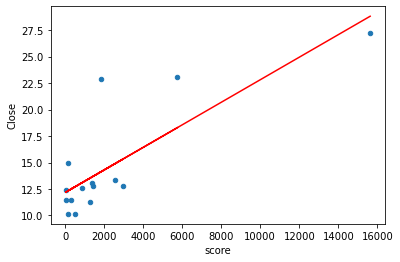

In [116]:
# visualization 


#mergedData.plot.scatter(x = 'score', y = 'Close')

# create a scatter plot of the data
mergedData.plot(kind='scatter', x='score', y='Close')

# fit a linear regression model to the data
slope, intercept = np.polyfit(mergedData['score'], mergedData['Close'], 1)

# add a regression line to the scatter plot
plt.plot(mergedData['score'], slope*mergedData['score'] + intercept, color='red')

# show the plot
plt.show()

# Miscilleanous 

In [10]:
#Creating a data frame with post data

posts = api.search_submissions(q= word_to_check, subreddit = subreddit, limit = 20, start_time = after, end_time = before)


posts_list=[]

for post in posts:
    posts_list.append(
        {"post_id": post.id, "post_title": post.title, "post_text": post.selftext,"score": post.score} 
    )


posts_df=pd.DataFrame(posts_list)


#posts_df["date"] = pd.to_datetime(posts_df["date"], unit="s").dt.date


display(posts_df)

/Users/daniilabbruzzese/opt/anaconda3/lib/python3.9/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


,post_id,post_title,post_text,score
0,ywt7cx,"Apes, it’s time! AMC, APE and GME to the moon!...",,1
1,yrnrdt,Time for a second movement?,Obviously the first round went well and we sho...,1
2,yqrdtm,"After holding GME since Feb 21, I finally thro...",,1
3,ypu9oj,Setting Wallstreet on fire with $UPST?,I found this very interesting stock $UPST (Ups...,1
4,yotviv,US Natural Gas to the moon!,this post is probably going to be downvoted ev...,1
5,ymtqhk,GME TO THE MOON I AM A TIME TRAVELER HEED MY W...,,1
6,yjpeu7,What are your predictions on GME. Is it going ...,,1
7,yiqds7,1.. 2.. 3.. GME TO THE MOON 🚀,,1
8,yict4a,Let’s RUN GME to the moon,,1
9,yics1n,They don’t want us to go to the MOON. #gme,,1
